# Initialization

Test notebook for the C-MAPPS benchmark. Approach using MLP. 

First we import the necessary packages and create the global variables.

In [5]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.font_manager
import matplotlib
import seaborn as sns
import pandas as pd
import time

import CMAPSAuxFunctions
#import plottingTools
#from datetime import datetime
#from sklearn.covariance import EllipticEnvelope
#from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#from sklearn.dummy import DummyClassifier
#from sklearn.model_selection import train_test_split, cross_validate
#from sklearn.neural_network import MLPClassifier
#from mpl_toolkits.mplot3d import Axes3D
#from dataManagement import DataManagerDamadics
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Dropout, Reshape, Conv2D, Flatten
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras import backend as K

from IPython.display import display, HTML
%matplotlib notebook

global constRUL

constRUL = 125
time_window = 30
rul_vector = None

CMAPSAuxFunctions.set_const_RUL(constRUL)

# Retrieve and Reshape data

Get the data from the text files, store it in a Pandas Dataframe and reshape it as appropiately.

In [6]:
data_file_train = '../CMAPSSData/train_FD001.txt'
data_file_test = '../CMAPSSData/test_FD001.txt'

#min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
standardScaler = StandardScaler()
min_max_scaler = MinMaxScaler(feature_range=(-1, 1))

#Selected as per CNN paper
selected_features = ['T24', 'T30', 'T50', 'P30', 'Nf', 'Nc', 'Ps30', 'phi', 'NRf', 'NRc', 
                     'BPR', 'htBleed', 'W31', 'W32']

nFeatures = len(selected_features)

#Get the X and y matrices with the specified time window
X_train, y_train = CMAPSAuxFunctions.retrieve_and_reshape_data(data_file_train, selected_features, time_window, 'train')
X_test, _ = CMAPSAuxFunctions.retrieve_and_reshape_data(data_file_test, selected_features, time_window, 'test')
y_test = np.loadtxt("../CMAPSSData/RUL_FD001.txt")
y_test = np.array([x if x < constRUL else constRUL for x in y_test])
y_test = np.reshape(y_test, (y_test.shape[0], 1))

#Standardize the data
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.fit_transform(X_test)

In [7]:
print("Training data")
print(X_train.shape)
print(y_train.shape)
print("Testing data")
print(X_test.shape)
print(y_test.shape)
print("Training data")
print(X_train[-5:,:])
print(y_train[-5:,:])
print("Testing data")
print(X_test[-5:,:])
print(y_test[-5:,:])

Training data
(17731, 420)
(17731, 1)
Testing data
(100, 420)
(100, 1)
Training data
[[ 0.62199313  0.32071611  0.36067504 ...  0.45454545 -0.4488189
  -0.77474791]
 [ 0.20962199  0.14475703  0.60204082 ...  0.09090909 -0.7480315
  -0.24669791]
 [ 0.12714777  0.14475703  0.71428571 ...  0.63636364 -0.52755906
  -0.88893623]
 [ 0.03092784  0.14475703  0.78296703 ...  0.09090909 -0.76377953
  -0.51768215]
 [ 0.26460481  0.15191816  0.50039246 ...  0.27272727 -0.63779528
  -0.55120011]]
[[4.]
 [3.]
 [2.]
 [1.]
 [0.]]
Testing data
[[-0.72682927 -0.95827124 -0.89279113 ... -0.71428571  0.45238095
   0.84135021]
 [ 0.13170732 -0.44336811 -0.39149723 ...  0.42857143 -0.38095238
   0.14388186]
 [-0.08292683 -0.01266766 -0.3323475  ...  0.14285714 -0.02380952
   0.42025316]
 [-0.49268293 -0.23919523 -0.92310536 ... -0.71428571  0.42857143
   0.41476793]
 [-0.32682927 -0.11698957  0.06617375 ...  0.71428571 -0.16666667
  -0.31940928]]
[[125.]
 [ 82.]
 [ 59.]
 [117.]
 [ 20.]]


# Keras model

We will use a very simple ANN for this example. The model is Dense(ReLU, 100)->Dense(ReLu, 100)->Dense(Linear, 1)

In [8]:
def RULmodel(input_shape):
    
    print(input_shape)
    
    #Create a sequential model
    model = Sequential()
    
    #Add the layers for the model
    model.add(Dense(1000, input_dim=input_shape, activation='tanh', kernel_initializer='glorot_normal', name='fc1'))
    model.add(Dropout(0.5))
    model.add(Dense(500, activation='tanh', kernel_initializer='glorot_normal', name='fc2'))
    model.add(Dropout(0.5))
    #model.add(Dense(100, activation='tanh', name='fc3'))
    #model.add(Dropout(0.5))
    #model.add(Dense(10, activation='tanh', name='fc4'))
    #model.add(Dropout(0.5))
    model.add(Dense(1, activation='linear', name='out'))
    
    #create a placeholder for the input
    #X_input = Input(shape=(input_shape))
    
    #Create the layers
    #X = Dense(100, activation='relu', name='fc1')(X_input)
    #X = Dense(100, activation='relu', name='fc2')(X)
    #X = Dense(1, activation='linear', name='out')(X)
    
    # Create model. This creates the Keras model instance, you'll use this instance to train/test the model.
    #model = Sequential(inputs = X_input, outputs = X, name='RUL')
    
    return model

# Fit the keras model
Fit the Keras model to the data and determine its performance.

In [9]:
lrate = LearningRateScheduler(CMAPSAuxFunctions.step_decay)

#Create the model
modelRUL = RULmodel(X_train.shape[1])

#Compile the model.
modelRUL.compile(optimizer = "adam", loss = "mean_squared_error", metrics = ["mse"])

startTime = time.clock()
#Train the model.
modelRUL.fit(x = X_train, y = y_train, epochs = 250, batch_size = 512, callbacks=[lrate])  
endTime = time.clock()

420
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch 1/250
17731/17731 [==============================] - 0s 23us/step - loss: 4370.9862 - mean_squared_error: 4370.9862
Epoch 2/250
17731/17731 [==============================] - 0s 10us/step - loss: 2550.2633 - mean_squared_error: 2550.2633
Epoch 3/250
17731/17731 [==============================] - 0s 10us/step - loss: 1577.4585 - mean_squared_error: 1577.4585
Epoch 4/250
17731/17731 [==============================] - 0s 10us/step - loss: 1057.5683 - mean_squared_error: 1057.5683
Epoch 5/250
17731/17731 [==============================] - 0s 10us/step - loss: 710.1794 - mean_squared_error: 710.1794
Epoch 6/250
17731/17731 [==============================] - 0s 11us/step - loss: 463.9401 - mean_squared_error: 463.9401
Epoch 7/250
17731/17731 [==============================] - 0s 10us/step - loss: 347.1760 - mean_squared_error: 347.1760
Epoch 8/250
17731/17731 [==============================] - 0s 10us/step - l

17731/17731 [==============================] - 0s 10us/step - loss: 143.6611 - mean_squared_error: 143.6611
Epoch 66/250
17731/17731 [==============================] - 0s 11us/step - loss: 141.0425 - mean_squared_error: 141.0425
Epoch 67/250
17731/17731 [==============================] - 0s 11us/step - loss: 141.6549 - mean_squared_error: 141.6549
Epoch 68/250
17731/17731 [==============================] - 0s 10us/step - loss: 141.6089 - mean_squared_error: 141.6089
Epoch 69/250
17731/17731 [==============================] - 0s 10us/step - loss: 141.5316 - mean_squared_error: 141.5316
Epoch 70/250
17731/17731 [==============================] - 0s 10us/step - loss: 141.7766 - mean_squared_error: 141.7766
Epoch 71/250
17731/17731 [==============================] - 0s 11us/step - loss: 141.4062 - mean_squared_error: 141.4062
Epoch 72/250
17731/17731 [==============================] - 0s 10us/step - loss: 139.4071 - mean_squared_error: 139.4071
Epoch 73/250
17731/17731 [===================

17731/17731 [==============================] - 0s 10us/step - loss: 115.2273 - mean_squared_error: 115.2273
Epoch 133/250
17731/17731 [==============================] - 0s 11us/step - loss: 116.7763 - mean_squared_error: 116.7763
Epoch 134/250
17731/17731 [==============================] - 0s 10us/step - loss: 115.2034 - mean_squared_error: 115.2034
Epoch 135/250
17731/17731 [==============================] - 0s 10us/step - loss: 113.2966 - mean_squared_error: 113.2966
Epoch 136/250
17731/17731 [==============================] - 0s 10us/step - loss: 112.8427 - mean_squared_error: 112.8427
Epoch 137/250
17731/17731 [==============================] - 0s 10us/step - loss: 113.5828 - mean_squared_error: 113.5828
Epoch 138/250
17731/17731 [==============================] - 0s 10us/step - loss: 112.7146 - mean_squared_error: 112.7146
Epoch 139/250
17731/17731 [==============================] - 0s 11us/step - loss: 114.4380 - mean_squared_error: 114.4380
Epoch 140/250
17731/17731 [===========

17731/17731 [==============================] - 0s 11us/step - loss: 99.4183 - mean_squared_error: 99.4183
Epoch 200/250
17731/17731 [==============================] - 0s 10us/step - loss: 100.6967 - mean_squared_error: 100.6967
Epoch 201/250
17731/17731 [==============================] - 0s 11us/step - loss: 98.6598 - mean_squared_error: 98.6598
Epoch 202/250
17731/17731 [==============================] - 0s 13us/step - loss: 96.8806 - mean_squared_error: 96.8806
Epoch 203/250
17731/17731 [==============================] - 0s 11us/step - loss: 94.8575 - mean_squared_error: 94.8575
Epoch 204/250
17731/17731 [==============================] - 0s 10us/step - loss: 95.6575 - mean_squared_error: 95.6575
Epoch 205/250
17731/17731 [==============================] - 0s 10us/step - loss: 95.1364 - mean_squared_error: 95.1364
Epoch 206/250
17731/17731 [==============================] - 0s 11us/step - loss: 94.4902 - mean_squared_error: 94.4902
Epoch 207/250
17731/17731 [=========================

In [10]:
#Evaluate the model
score = modelRUL.evaluate(x = X_test, y = y_test)
y_pred = modelRUL.predict(X_test)
healtScore = CMAPSAuxFunctions.compute_health_score(y_test, y_pred)

print("Root Square Mean Error score: {}".format(np.sqrt(score[0])))
print("Health score: {}".format(healtScore))
print("Elapsed time: {}".format(endTime - startTime))

100/100 [==============================] - 0s 280us/step
Root Square Mean Error score: 18.808270181536624
Health score: [810.56449344]
Elapsed time: 46.8218312925661


# CNN Model
Fit the Keras model to the data using a CNN and determine its performance.

# Initialization

In [11]:
import os, math, random, pickle, time
import numpy as np
import tensorflow as tf
from keras.callbacks import TensorBoard, ModelCheckpoint, LearningRateScheduler,EarlyStopping
from keras.models import Sequential, Model, load_model
from keras.layers.pooling import AveragePooling1D, MaxPooling1D
from keras.layers import Dense, Dropout, Activation, Input, merge, Conv2D, Reshape, Flatten, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, SGD
import keras
from sklearn import preprocessing
from keras import backend as K
from keras import metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import CMAPSAuxFunctions

# Constants

In [12]:
FeatureN = 14
nb_epoch = 250
batch_size = 512
FilterN = 10
FilterL = 10
rmse,sco,tm = [], [], []

ConstRUL = 125
TW = 30
Dataset = '1'

# Reshape data to fit a convNet

In [13]:
samples = np.reshape(X_train, newshape=(X_train.shape[0], int(X_train.shape[1]/nFeatures), nFeatures))
samplet = np.reshape(X_test, newshape=(X_test.shape[0], int(X_test.shape[1]/nFeatures), nFeatures))
targets = y_train
labelt = y_test
print("Training data")
print(samples.shape)
print(targets.shape)
print("Testing data")
print(samplet.shape)
print(labelt.shape)
print("Training data")
print(samples[-5:,:])
print(targets[-5:])
print("Testing data")
print(samplet[-5:,:])
print(labelt[-5:])

Training data
(17731, 30, 14)
(17731, 1)
Testing data
(100, 30, 14)
(100, 1)
Training data
[[[ 0.62199313  0.32071611  0.36067504 ...  0.6        -0.51851852
   -0.17989737]
  [ 0.19322034  0.14475703  0.60204082 ...  0.4        -0.51851852
   -0.07425294]
  [ 0.11186441  0.14475703  0.71428571 ...  0.4        -0.33333333
   -0.21430727]
  ...
  [ 0.52583587  0.14453891  0.60540348 ... -0.09090909 -0.62790698
   -0.33108677]
  [ 0.3253012   0.26444299  0.76501955 ... -0.09090909 -1.
   -0.1628756 ]
  [ 0.37349398  0.17462394  0.5658339  ...  0.45454545 -0.4488189
   -0.77474791]]

 [[ 0.20962199  0.14475703  0.60204082 ...  0.4        -0.51851852
   -0.07425294]
  [ 0.11186441  0.14475703  0.71428571 ...  0.4        -0.33333333
   -0.21430727]
  [ 0.01694915  0.14475703  0.78296703 ...  0.2        -0.48148148
   -0.39480833]
  ...
  [ 0.33738602  0.26444299  0.76501955 ... -0.09090909 -1.
   -0.1628756 ]
  [ 0.37349398  0.17462394  0.64877355 ...  0.45454545 -0.4488189
   -0.77730974]


# Keras model

CNN model. The model is Dense(ReLU, 100)->Dense(ReLu, 100)->Dense(Linear, 1)

In [14]:
def RULCNNModel(TW, FeatureN):
    
    input_layer = Input(shape=(TW, FeatureN))
    y = Reshape((TW, FeatureN, 1), input_shape=(TW, FeatureN, ),name = 'Reshape')(input_layer)

    y = Conv2D(FilterN, FilterL, 1, border_mode='same', kernel_initializer='glorot_normal', activation='tanh', name='C1')(y)
    y = Conv2D(FilterN, FilterL, 1, border_mode='same', kernel_initializer='glorot_normal', activation='tanh', name='C2')(y)
    y = Conv2D(FilterN, FilterL, 1, border_mode='same', kernel_initializer='glorot_normal', activation='tanh', name='C3')(y)
    y = Conv2D(FilterN, FilterL, 1, border_mode='same', kernel_initializer='glorot_normal', activation='tanh', name='C4')(y)
    #y = Convolution2D(FilterN, FilterL, 1, border_mode='same', init='glorot_normal', activation='tanh', name='C5')(y)
    #y = Convolution2D(FilterN, FilterL, 1, border_mode='same', init='glorot_normal', activation='tanh', name='C6')(y)
    
    y = Conv2D(1, 3, 1, border_mode='same', kernel_initializer='glorot_normal', activation='tanh', name='Clast')(y)  
    
    y = Reshape((TW,14))(y)
    y = Flatten()(y)
    y = Dropout(0.5)(y)
    
    #y = Dense(100, activation='tanh', init='glorot_normal', activity_regularizer=keras.regularizers.l2(0.01),)(y)
    y = Dense(100,activation='tanh', kernel_initializer='glorot_normal', name='fc')(y)
    y = Dense(1)(y)
    
    model = Model(inputs = input_layer, outputs = y, name='RUL_CNN_Model')
    
    return model

# Fit the keras model

Fit the Keras model to the data and determine its performance.

In [15]:
opt = Adam(lr=0, beta_1=0.5)
#DCNN = Model([input_layer], [y])
DCNN = RULCNNModel(TW, FeatureN)
#DCNN.compile(loss=get_score,optimizer=opt)
DCNN.compile(loss='mean_squared_error',optimizer=opt)
lrate = LearningRateScheduler(CMAPSAuxFunctions.step_decay)


startTime = time.clock()
history = DCNN.fit(samples, targets,nb_epoch=nb_epoch, batch_size=batch_size,verbose=1, 
                   validation_data=(samplet, labelt), callbacks=[lrate])
endTime = time.clock()

Instructions for updating:
keep_dims is deprecated, use keepdims instead


C:\Users\controlslab\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (10, 1), name="C1", kernel_initializer="glorot_normal", padding="same", activation="tanh")`
  
C:\Users\controlslab\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (10, 1), name="C2", kernel_initializer="glorot_normal", padding="same", activation="tanh")`
  import sys
C:\Users\controlslab\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (10, 1), name="C3", kernel_initializer="glorot_normal", padding="same", activation="tanh")`
  
C:\Users\controlslab\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (10, 1), name="C4", kernel_initializer="glorot_normal", paddi

Train on 17731 samples, validate on 100 samples
Epoch 1/250
17731/17731 [==============================] - 1s 70us/step - loss: 6724.2366 - val_loss: 5141.2632
Epoch 2/250
17731/17731 [==============================] - 0s 22us/step - loss: 5792.4779 - val_loss: 4735.1108
Epoch 3/250
17731/17731 [==============================] - 0s 22us/step - loss: 5335.0267 - val_loss: 4375.4873
Epoch 4/250
17731/17731 [==============================] - 0s 22us/step - loss: 4924.3052 - val_loss: 4048.5806
Epoch 5/250
17731/17731 [==============================] - 0s 22us/step - loss: 4548.2618 - val_loss: 3707.0601
Epoch 6/250
17731/17731 [==============================] - 0s 22us/step - loss: 4201.4270 - val_loss: 3396.3652
Epoch 7/250
17731/17731 [==============================] - 0s 22us/step - loss: 3880.9442 - val_loss: 3103.9163
Epoch 8/250
17731/17731 [==============================] - 0s 22us/step - loss: 3585.8758 - val_loss: 2833.0815
Epoch 9/250
17731/17731 [==============================]

17731/17731 [==============================] - 0s 22us/step - loss: 176.5707 - val_loss: 197.4415
Epoch 75/250
17731/17731 [==============================] - 0s 21us/step - loss: 179.0862 - val_loss: 205.5661
Epoch 76/250
17731/17731 [==============================] - 0s 22us/step - loss: 176.0208 - val_loss: 224.5067
Epoch 77/250
17731/17731 [==============================] - 0s 22us/step - loss: 173.5438 - val_loss: 214.6123
Epoch 78/250
17731/17731 [==============================] - 0s 22us/step - loss: 173.7282 - val_loss: 218.8836
Epoch 79/250
17731/17731 [==============================] - 0s 22us/step - loss: 176.3489 - val_loss: 192.4127
Epoch 80/250
17731/17731 [==============================] - 0s 22us/step - loss: 171.5413 - val_loss: 202.5969
Epoch 81/250
17731/17731 [==============================] - 0s 22us/step - loss: 170.1303 - val_loss: 181.3559
Epoch 82/250
17731/17731 [==============================] - 0s 22us/step - loss: 167.4393 - val_loss: 239.2974
Epoch 83/250
1

17731/17731 [==============================] - 0s 22us/step - loss: 136.7453 - val_loss: 235.4097
Epoch 148/250
17731/17731 [==============================] - 0s 22us/step - loss: 135.8989 - val_loss: 208.1134
Epoch 149/250
17731/17731 [==============================] - 0s 22us/step - loss: 140.4698 - val_loss: 202.7608
Epoch 150/250
17731/17731 [==============================] - 0s 22us/step - loss: 134.2353 - val_loss: 199.7300
Epoch 151/250
17731/17731 [==============================] - 0s 22us/step - loss: 139.8386 - val_loss: 233.1853
Epoch 152/250
17731/17731 [==============================] - 0s 22us/step - loss: 133.7439 - val_loss: 255.1394
Epoch 153/250
17731/17731 [==============================] - 0s 22us/step - loss: 137.1450 - val_loss: 232.0940
Epoch 154/250
17731/17731 [==============================] - 0s 22us/step - loss: 139.7177 - val_loss: 226.9356
Epoch 155/250
17731/17731 [==============================] - 0s 22us/step - loss: 140.1220 - val_loss: 212.1326
Epoch 

17731/17731 [==============================] - 0s 22us/step - loss: 120.3851 - val_loss: 239.6572
Epoch 221/250
17731/17731 [==============================] - 0s 22us/step - loss: 120.2320 - val_loss: 233.0036
Epoch 222/250
17731/17731 [==============================] - 0s 22us/step - loss: 119.8007 - val_loss: 240.1329
Epoch 223/250
17731/17731 [==============================] - 0s 22us/step - loss: 120.0825 - val_loss: 240.8490
Epoch 224/250
17731/17731 [==============================] - 0s 22us/step - loss: 120.6047 - val_loss: 233.6133
Epoch 225/250
17731/17731 [==============================] - 0s 21us/step - loss: 121.2488 - val_loss: 240.9664
Epoch 226/250
17731/17731 [==============================] - 0s 22us/step - loss: 121.8035 - val_loss: 239.3516
Epoch 227/250
17731/17731 [==============================] - 0s 22us/step - loss: 122.5054 - val_loss: 246.0075
Epoch 228/250
17731/17731 [==============================] - 0s 22us/step - loss: 120.6223 - val_loss: 239.9877
Epoch 

In [16]:
#Evaluate the model
score = DCNN.evaluate(samplet, labelt)
y_pred = DCNN.predict(samplet)
healtScore = CMAPSAuxFunctions.compute_health_score(labelt, y_pred)

print("Root Square Mean Error score: {}".format(np.sqrt(score)))
print("Health score: {}".format(healtScore))
print("Elapsed time: {}".format(endTime - startTime))

100/100 [==============================] - 0s 130us/step
Root Square Mean Error score: 15.556290215960974
Health score: [315.79900664]
Elapsed time: 98.86524621595383


<IPython.core.display.Javascript object>


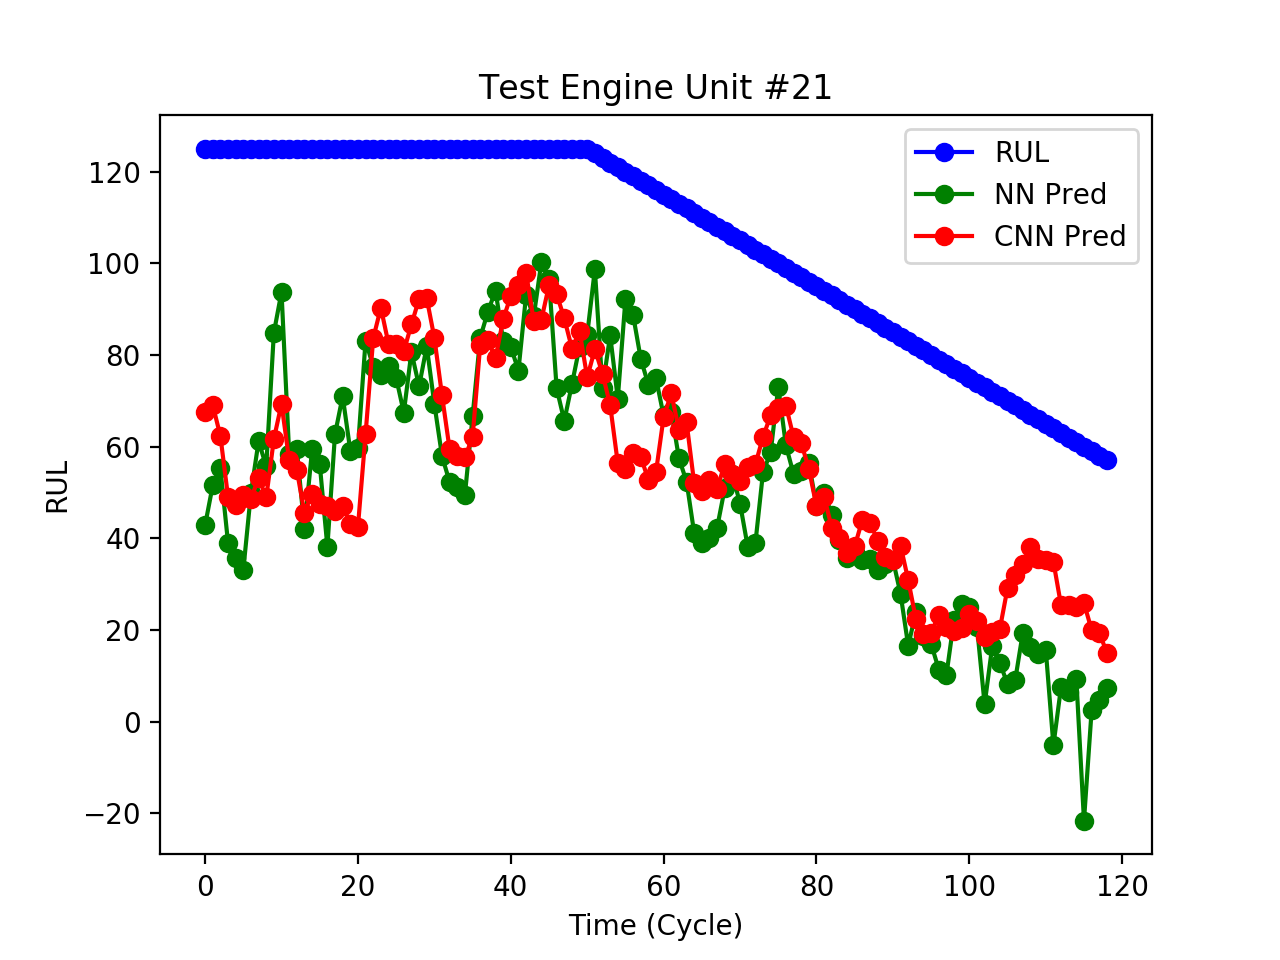

In [43]:
engineUnit = 21

X_test2, _ = CMAPSAuxFunctions.retrieve_and_reshape_data(data_file_test, selected_features, time_window, 'train', unit_Number=engineUnit)
X_test2 = min_max_scaler.fit_transform(X_test2)

samplet2 = np.reshape(X_test2, newshape=(X_test2.shape[0], int(X_test2.shape[1]/nFeatures), nFeatures))

nnPred = modelRUL.predict(X_test2)
cnnPred = DCNN.predict(samplet2)

maxCycle = X_test2.shape[0]
faultCycle = y_test[unit-1]
cycles = np.arange(maxCycle)
rulArray = np.arange(faultCycle, maxCycle+faultCycle)
rulArray[rulArray > constRUL] = constRUL
rulArray = np.flipud(rulArray)

#print(cycles)
#print(rulArray)

'''print("Testing data")
print(X_test2.shape)
print(X_test2[-5:,:])
print(nnPred)
print(cnnPred)'''

plotRUL(cycles, rulArray, nnPred, cnnPred, engineUnit)

In [41]:
def plotRUL(cycles, rulArray, nnPred, cnnPred, engineUnit):
    
    plt.clf()
    plt.plot(cycles, rulArray, 'bo-', label='RUL')
    plt.plot(cycles, nnPred, 'go-', label='NN Pred')
    plt.plot(cycles, cnnPred, 'ro-', label='CNN Pred')
    plt.legend()
    plt.xlabel("Time (Cycle)")
    plt.ylabel("RUL")
    plt.title("Test Engine Unit #{}".format(engineUnit))
    plt.show()